# San Francisco Crime Classification

Authors: Chiara Angileri, Livia Del Gaudio, Giorgia Pavani

### Import libraries

In [1]:
!pip install scikit-learn

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from pyspark.sql.functions import *

from pyspark.ml.feature import *
from pyspark.ml import Pipeline

from pyspark.ml.classification import DecisionTreeClassifier, NaiveBayes, LogisticRegression, RandomForestClassifier

from sklearn.metrics import log_loss
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


In [3]:
#Geopandas
!pip3 install geopandas
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame

# Load the data

In [50]:
def load_data(split):
    df = spark.read.format("csv")\
                    .option("sep", ",")\
                    .option("header", "True")\
                    .option("inferSchema", "True")\
                    .option("path",f"bigdata/Project/dataset/{split}.csv").load()
    return df

In [51]:
sfcrime_train = load_data("train")
sfcrime_test = load_data("test")

In [5]:
sfcrime_train.printSchema()

root
 |-- Dates: timestamp (nullable = true)
 |-- Category: string (nullable = true)
 |-- Descript: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- PdDistrict: string (nullable = true)
 |-- Resolution: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- X: double (nullable = true)
 |-- Y: double (nullable = true)



In [4]:
# Visualize the data
sfcrime_train.show(5)

+-------------------+--------------+--------------------+---------+----------+--------------+--------------------+-------------------+------------------+
|              Dates|      Category|            Descript|DayOfWeek|PdDistrict|    Resolution|             Address|                  X|                 Y|
+-------------------+--------------+--------------------+---------+----------+--------------+--------------------+-------------------+------------------+
|2015-05-13 23:53:00|      WARRANTS|      WARRANT ARREST|Wednesday|  NORTHERN|ARREST, BOOKED|  OAK ST / LAGUNA ST|  -122.425891675136|  37.7745985956747|
|2015-05-13 23:53:00|OTHER OFFENSES|TRAFFIC VIOLATION...|Wednesday|  NORTHERN|ARREST, BOOKED|  OAK ST / LAGUNA ST|  -122.425891675136|  37.7745985956747|
|2015-05-13 23:33:00|OTHER OFFENSES|TRAFFIC VIOLATION...|Wednesday|  NORTHERN|ARREST, BOOKED|VANNESS AV / GREE...|   -122.42436302145|  37.8004143219856|
|2015-05-13 23:30:00| LARCENY/THEFT|GRAND THEFT FROM ...|Wednesday|  NORTHER

## Data Preprocessing

Steps done in preprocessing:
- feature extraction
- drop duplicate rows
- null removal
- outliers removal

In [5]:
def preprocess_data(df, split):  
    # Extract features from date 
    df = df.withColumn('Hour', hour("Dates"))\
            .withColumn('Month', month("Dates"))\
            .withColumn('Year', year("Dates"))

    # Drop duplicate rows
    prev_count = df.count()
    df = df.dropDuplicates()
    print(f"Number of duplicated rows in the {split} split: ", prev_count - df.count())

    # Nulls removal
    df.na.drop()

    #plot_outliers(df) 

    # Outliers removal
    prev_count = df.count()
    df = df.where((df.X < -122) & (df.X > -123) & (df.Y < 38) & (df.Y > 37))
    print(f"Number of outliers in the {split} split: ", prev_count - df.count())
        
    # Normalize X, Y coordinates 
    for i in ["X","Y"]:
        assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")
        scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")
        pipeline = Pipeline(stages=[assembler, scaler])
        df = pipeline.fit(df).transform(df)

    # Drop unused columns
    df = df.drop("Dates")
    df = df.drop("X_Vect","Y_Vect", "X", "Y")

    return df    

In [54]:
sfcrime_train = preprocess_data(sfcrime_train, "train")
sfcrime_test = preprocess_data(sfcrime_test, "test")

Number of duplicated rows in the train split:  2323


Number of outliers in the train split:  67


Number of duplicated rows in the test split:  0


Number of outliers in the test split:  76


In [8]:
sfcrime_train.show(5)

+--------------+--------------------+---------+----------+--------------+--------------------+----+-----+----+--------------------+--------------------+
|      Category|            Descript|DayOfWeek|PdDistrict|    Resolution|             Address|Hour|Month|Year|            X_Scaled|            Y_Scaled|
+--------------+--------------------+---------+----------+--------------+--------------------+----+-----+----+--------------------+--------------------+
|      BURGLARY|BURGLARY, UNLAWFU...|Wednesday|  NORTHERN|          NONE|2300 Block of FIL...|  13|    5|2015|[0.5331389416346913]|[0.7428616292488223]|
| VEHICLE THEFT|   STOLEN AUTOMOBILE|  Tuesday| INGLESIDE|          NONE|ALEMANY BL / ONON...|  21|    5|2015|[0.5043534508595877]|[0.12263853306963...|
| LARCENY/THEFT|GRAND THEFT FROM ...|   Monday|  NORTHERN|          NONE|   BUSH ST / POLK ST|  21|    5|2015|[0.6276519170675439]|[0.7209854943264132]|
| LARCENY/THEFT|GRAND THEFT SHOPL...|   Monday|  SOUTHERN|          NONE|700 Block

In [11]:
sfcrime_test.show(5)

+----+---------+----------+--------------------+----+-----+----+--------------------+--------------------+
|  Id|DayOfWeek|PdDistrict|             Address|Hour|Month|Year|            X_Scaled|            Y_Scaled|
+----+---------+----------+--------------------+----+-----+----+--------------------+--------------------+
|  87|   Sunday|   BAYVIEW|700 Block of LECO...|  18|    5|2015|[0.7855694904453973]|[0.07843505525780...|
| 110|   Sunday|   MISSION|24TH ST / MISSION ST|  16|    5|2015|[0.6393512575535026]|[0.3934666351664633]|
| 238|   Sunday|TENDERLOIN| 0 Block of GROVE ST|   8|    5|2015|[0.6581198824953696]|  [0.62834386957021]|
|2055|  Tuesday|  SOUTHERN|SOUTH VAN NESS AV...|  21|    5|2015|[0.6382043324523972]|[0.5780777253955534]|
|3421| Saturday|TENDERLOIN|400 Block of ELLI...|  13|    4|2015|[0.6718505047854885]|[0.6813610818935804]|
+----+---------+----------+--------------------+----+-----+----+--------------------+--------------------+
only showing top 5 rows



In [16]:
'''
!pip3 install geopandas
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
'''

# Outliers : https://www.kaggle.com/code/bananawolf/random-forest-knn-logistic-regression

'''
sfcrime_pd = sfcrime.toPandas()

geometry = [Point(xy) for xy in zip(sfcrime_pd['X'], sfcrime_pd['Y'])]
gdf = GeoDataFrame(sfcrime_pd, geometry=geometry)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(), marker='o', color='red')
plt.show()
'''

"\nsfcrime_pd = sfcrime.toPandas()\n\ngeometry = [Point(xy) for xy in zip(sfcrime_pd['X'], sfcrime_pd['Y'])]\ngdf = GeoDataFrame(sfcrime_pd, geometry=geometry)\n\nworld = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))\ngdf.plot(ax=world.plot(), marker='o', color='red')\nplt.show()\n"

From the previous image, we can observe that there are some erroneus coordinates that do not refer to San Francisco geographic coordinates. They may be due to mislabelling errors, and we consider them as outliers, therefore we remove them from the dataset. 

## Dataset inspection

In [13]:
plot = False
if plot:
    sfcrime_train_pd = sfcrime_train.toPandas().copy()
    
    # Select the top 10 crimes and group the rest into 'Other crimes'
    top10 = sfcrime_train_pd['Category'].value_counts().head(10).index.tolist()
    sfcrime_train_top_10 = sfcrime_train_pd.copy()
    sfcrime_train_top_10.loc[~sfcrime_train_pd['Category'].isin(top10), 'Category'] = 'Other crimes'


### Distribution of crimes

In [18]:
def crime_distribution(df, plot = True):
    if plot:
        df.groupBy("Category").count().orderBy("count", ascending=False).toPandas().plot(kind='bar', x='Category', y='count', log=True, figsize=(20,10))
        plt.title('Distribution of crimes')
        plt.show()

crime_distribution(sfcrime_train, plot = plot)    

### Distributions of crimes among districts

In [19]:
def crime_distribution_among_districts(df, df_copy_top_10, plot = True):
    if plot:
        df.groupBy("PdDistrict").count().orderBy("count", ascending=False).toPandas().plot(kind='bar', x='PdDistrict', y='count', figsize=(10,5))
        plt.title('Distribution of crimes among districts')
        plt.xlabel('Districts')
        plt.show()
        
        # Analyze the different categories of crimes per district
        df_copy_top_10.groupby(['PdDistrict','Category'])\
                    .agg({'Resolution':'count'})\
                    .pivot_table(index='PdDistrict',columns='Category')['Resolution']\
                    .plot(kind='bar',stacked=True,figsize=(12,8))
        plt.title('Distribution of crimes among districts')

crime_distribution_among_districts(sfcrime_train, sfcrime_train_top_10, plot = plot)

NameError: name 'sfcrime_train_top_10' is not defined

### Distribution of crimes among years

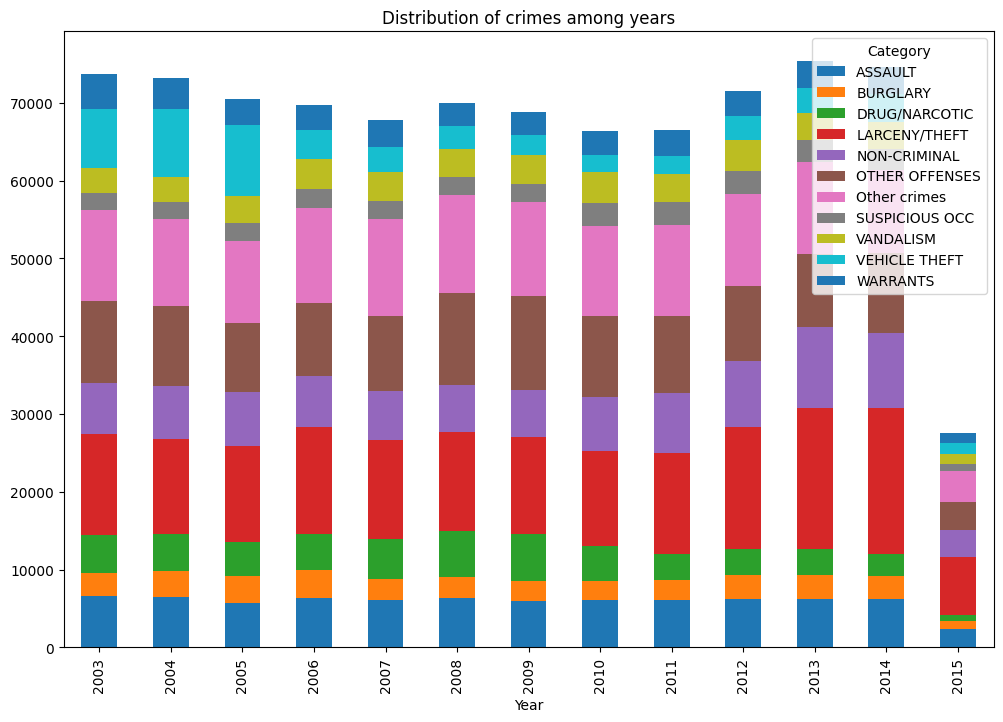

In [ ]:
def crime_distribution_among_years(df_copy_top_10, plot = True):
    if plot:
        df_copy_top_10.groupby(['Year','Category'])\
                        .agg({'Resolution':'count'})\
                        .pivot_table(index='Year',columns='Category')['Resolution']\
                        .plot(kind='bar',stacked=True,figsize=(12,8))

        plt.title('Distribution of crimes among years')
        plt.show()

crime_distribution_among_years(sfcrime_train_top_10, plot = plot)

In 2015 there is a drop in the number of crimes because the dataset contains the crimes until may 2015. 

### Distribution of crimes among hours

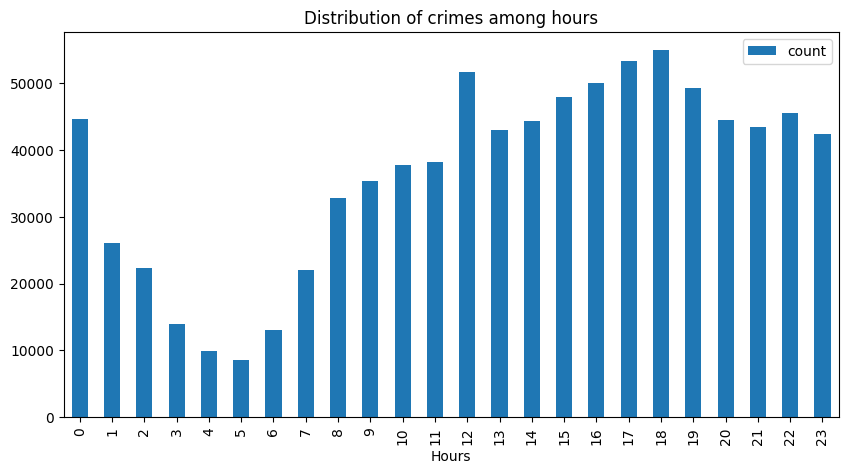

In [ ]:
def crime_distribution_among_hours(df, plot = True):
    if plot:
        df.groupBy("Hour").count().orderBy("hour", ascending=True).toPandas().plot(kind='bar', x='Hour', y='count', figsize=(10,5))
        plt.title('Distribution of crimes among hours')
        plt.xlabel('Hours')
        plt.show()

crime_distribution_among_hours(sfcrime_train, plot = plot)

### Distribution of crimes among days

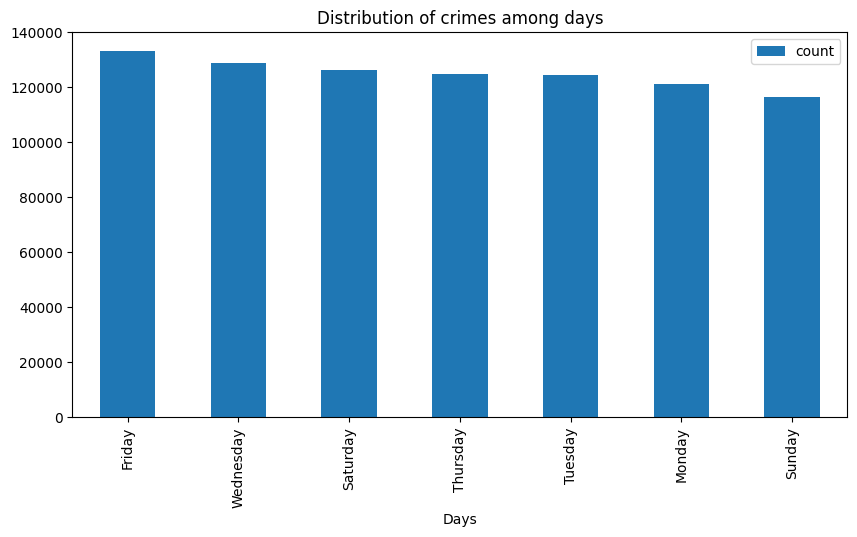

In [ ]:
def crime_distribution_among_days(df, plot = True):
    if plot:
        df.groupBy('DayOfWeek').count().orderBy('count', ascending=False).toPandas().plot(kind='bar', x='DayOfWeek', y='count', figsize=(10, 5))
        plt.title('Distribution of crimes among days')
        plt.xlabel('Days')
        plt.show()

crime_distribution_among_days(sfcrime_train, plot = plot)

### Trends of crimes during the week -- TODO: scrivere se si evidenzia qualche trend

In [ ]:
def weekly_trend(df, category):
    sfcrime_category = df[df['Category']==category]
    sfcrime_category.groupby(['DayOfWeek','Category'])\
                .agg({'Resolution':'count'})\
                .pivot_table(index='DayOfWeek',columns='Category')['Resolution']\
                .reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])\
                .plot(kind='line',figsize=(8,5))
    plt.title('Weekly trend of the category: ' + category)
    plt.xlabel('Day of the week')
    plt.ylabel('Count')
    plt.show()

def plot_trend(df, category, plot = True):
    if plot:        
        weekly_trend(df, category)

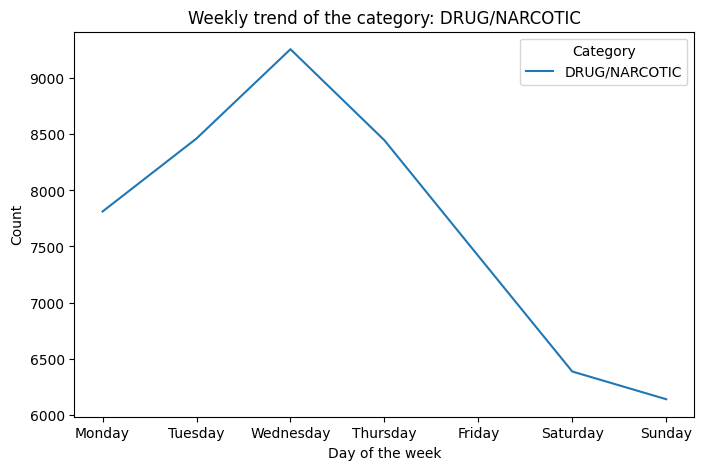

In [ ]:
plot_trend(sfcrime_train_pd, 'DRUG/NARCOTIC', plot = plot)

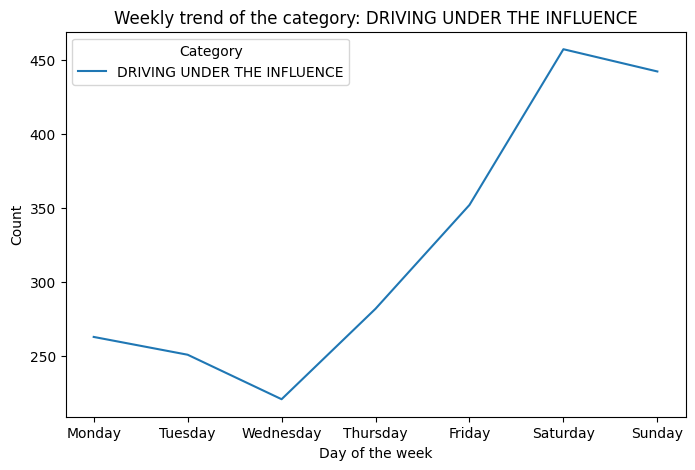

In [ ]:
plot_trend(sfcrime_train_pd, 'DRIVING UNDER THE INFLUENCE', plot = plot)

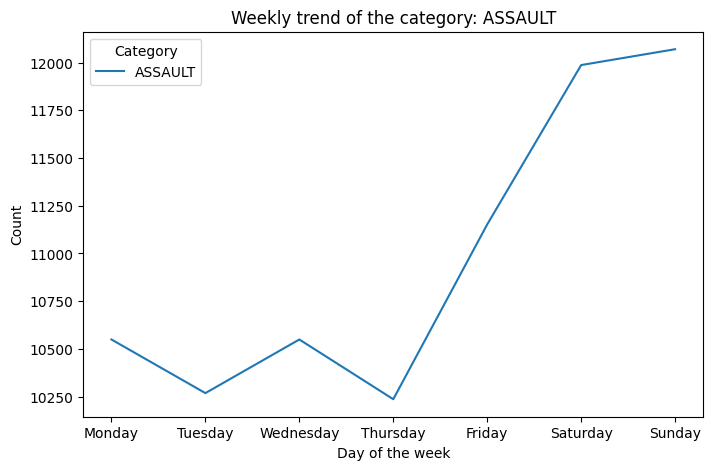

In [ ]:
plot_trend(sfcrime_train_pd, 'ASSAULT', plot = plot)

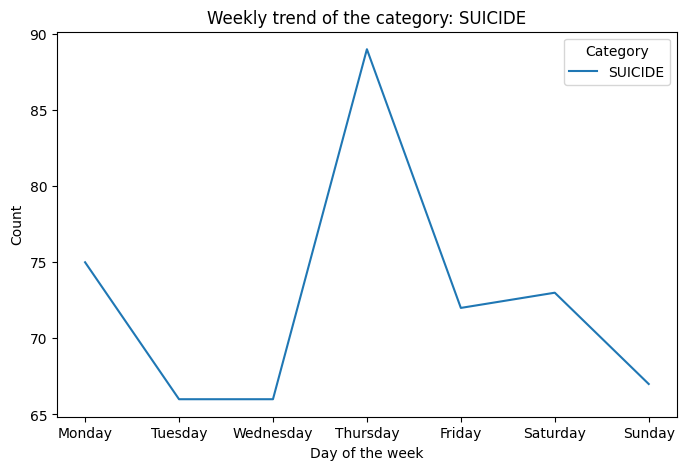

In [ ]:
plot_trend(sfcrime_train_pd, 'SUICIDE', plot = plot)

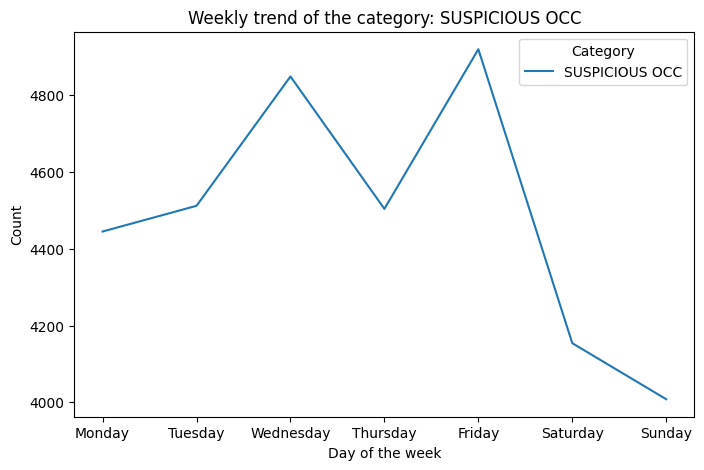

In [ ]:
plot_trend(sfcrime_train_pd, 'SUSPICIOUS OCC', plot = plot)

### Distribution of crimes among different addresses --- CHECK

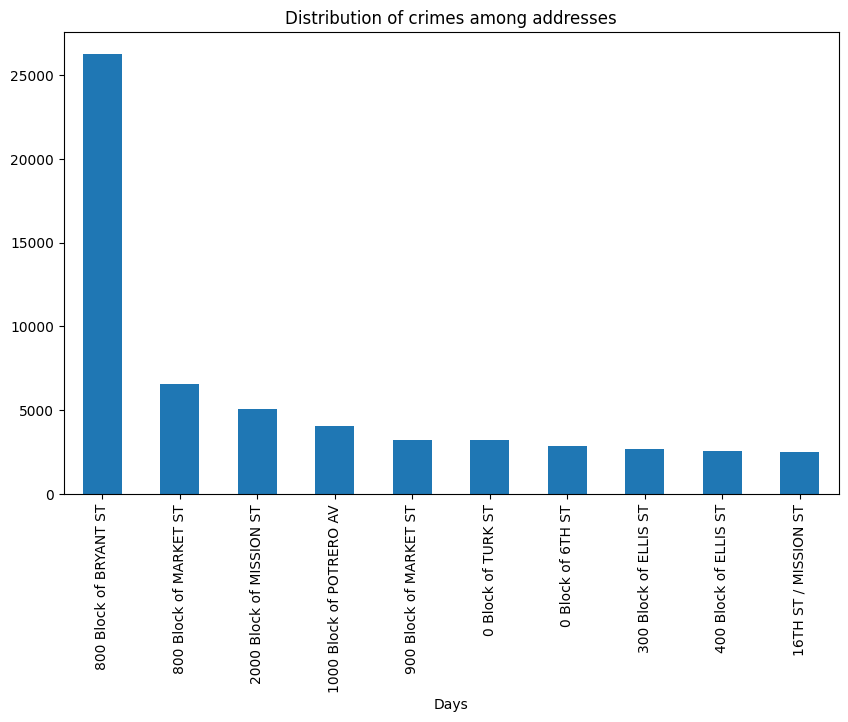

In [ ]:
def crime_distribution_among_addresses(df_top_10, plot = True):
    if plot:
        df_top_10['Address'].value_counts().head(10).plot(kind='bar',figsize=(10,6))
        plt.title('Distribution of crimes among addresses')
        plt.xlabel('Days')
        plt.show()

crime_distribution_among_addresses(sfcrime_train_top_10, plot = plot)

TODO: possiamo vedere che la maggior parte hanno la parola block quindi magari è importante ecc.. e si puo aggiungere come feauture togliendo l'address...........

### How the crimes have been resolved? --- TODO scrivere cosa si vede dai res

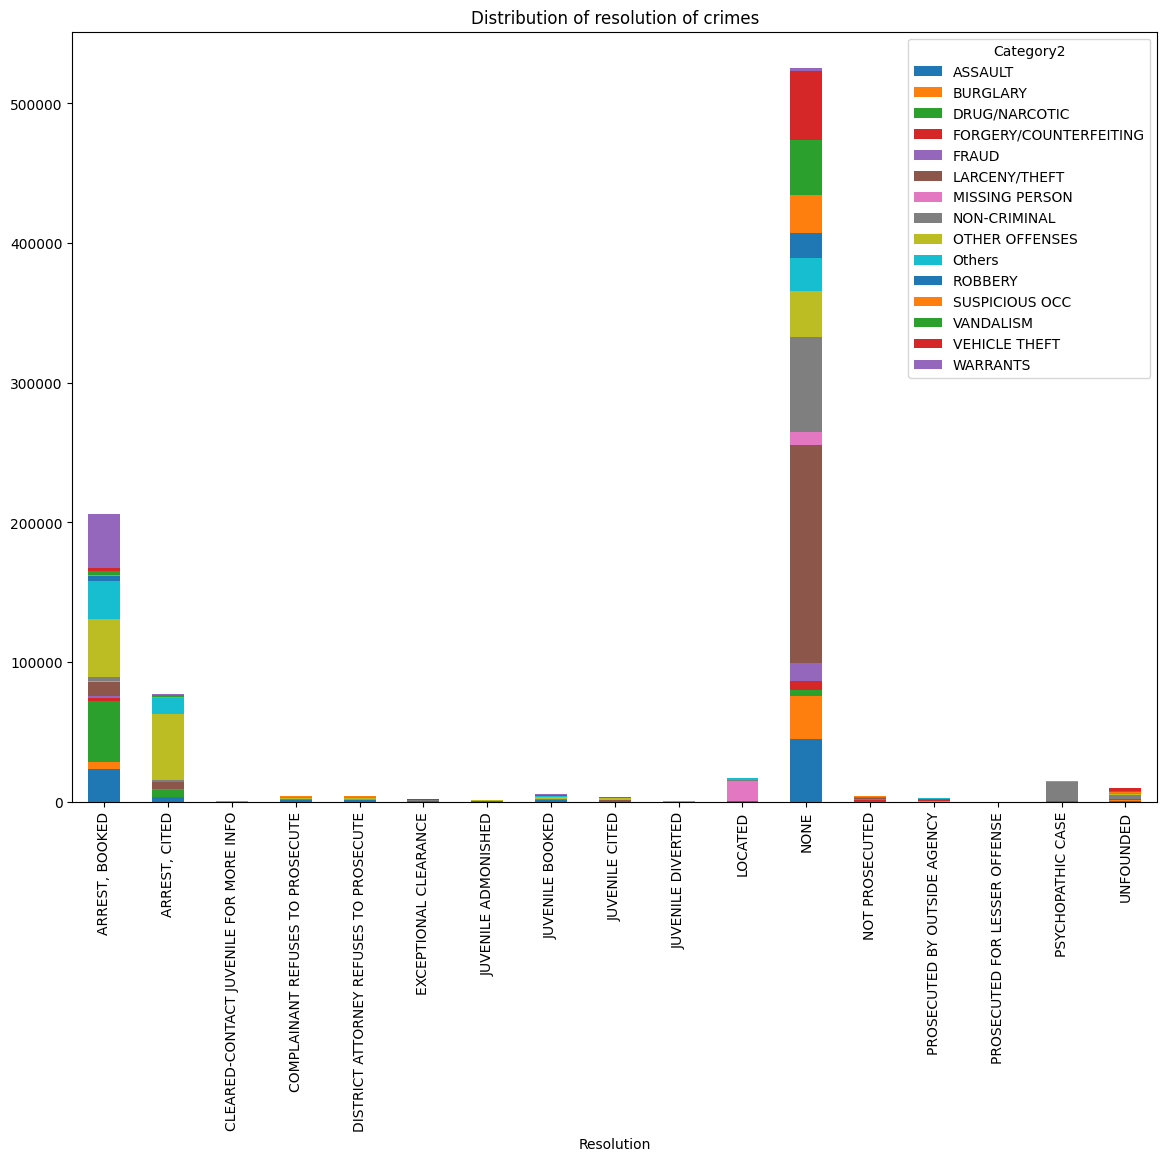

In [ ]:
def crime_distribution_resolution(df, plot = True):
    if plot:
        cats_relevant = df['Category'].value_counts()[df['Category'].value_counts() > 10000].index
        df['Category2'] = df['Category'].apply(lambda x: 'Others' if x not in cats_relevant else x)
        df['Category2'].unique()

        df.groupby(['Resolution','Category2']).\
            agg({'PdDistrict':'count'}).\
            pivot_table(index='Resolution',columns='Category2')['PdDistrict'].\
            plot(kind='bar',stacked=True,figsize=(14,10))

        plt.title('Distribution of resolution of crimes')
        plt.show()

crime_distribution_resolution(sfcrime_train_pd, plot = plot)

## Re-process the dataset after having inspected it: 
- transform to categorical le colonne.......
- extract blocl feature ...
- tokenize descript...
- drop le altre colimns

In [57]:
def process_data_after_inspection(df, split):

    # Transform columns to categorical
    indexer = StringIndexer(inputCol="PdDistrict", outputCol="PdDistrict_cat")
    df = indexer.fit(df).transform(df)

    if split == "train":
        indexer = StringIndexer(inputCol="Category", outputCol="Category_cat")
        df = indexer.fit(df).transform(df)
    
        indexer = StringIndexer(inputCol="Resolution", outputCol="Resolution_cat")
        df = indexer.fit(df).transform(df)

        # Preprocess Descript column with tokenizer
        tokenizer = Tokenizer(inputCol="Descript", outputCol="Descript_token")
        df = tokenizer.transform(df)

        # Transform the 'description_token' column with count vector
        vectorizer = CountVectorizer(inputCol="Descript_token", outputCol="Descript_vec")
        model = vectorizer.fit(df)
        df = model.transform(df)

    indexer = StringIndexer(inputCol="DayOfWeek", outputCol="DayOfWeek_cat")
    df = indexer.fit(df).transform(df)

    # Drop no more needed columns
    df = df.drop("PdDistrict")\
            .drop("Category")\
            .drop("DayOfWeek")\
            .drop("Resolution")\
            .drop("Descript")\
            .drop("Descript_token")
    

    # Block feature extraction: 1 if block present, 0 otherwise
    df = df.withColumn('Block', when(df.Address.like("%Block%") , lit(1)).otherwise(lit(0)))

    # Drop the 'address' column since we already have (x, y) coordinates and the block feature
    df = df.drop("Address")
    
    return df

In [58]:
sfcrime_train = process_data_after_inspection(sfcrime_train, "train")
sfcrime_train.show()

+----+-----+----+--------------------+--------------------+--------------+------------+--------------+--------------------+-------------+-----+
|Hour|Month|Year|            X_Scaled|            Y_Scaled|PdDistrict_cat|Category_cat|Resolution_cat|        Descript_vec|DayOfWeek_cat|Block|
+----+-----+----+--------------------+--------------------+--------------+------------+--------------+--------------------+-------------+-----+
|  13|    5|2015|[0.5331389416346913]|[0.7428616292488223]|           2.0|         8.0|           0.0|(1086,[17,40,77],...|          1.0|    1|
|  21|    5|2015|[0.5043534508595877]|[0.12263853306963...|           6.0|         5.0|           0.0|(1086,[10,24],[1....|          4.0|    0|
|  21|    5|2015|[0.6276519170675439]|[0.7209854943264132]|           2.0|         0.0|           0.0|(1086,[0,2,3,4,5]...|          5.0|    0|
|  19|    5|2015| [0.737858397882899]|[0.7068650434402454]|           0.0|         0.0|           0.0|(1086,[0,3,62],[1...|          5.0

In [59]:
sfcrime_test = process_data_after_inspection(sfcrime_test, "test")

In [60]:
# save sfcrime_train and sfcrime_test
sfcrime_train.write.mode("overwrite").option("path", "bigdata/Project/dataset/sfcrime_train_processed").saveAsTable("sfcrime_train_processed")
sfcrime_test.write.mode("overwrite").option("path", "bigdata/Project/dataset/sfcrime_test_processed").saveAsTable("sfcrime_test_processed")

23/12/29 10:31:21 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
23/12/29 10:31:33 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


In [4]:
# load sfcrime_train and sfcrime_test
sfcrime_train = spark.table("sfcrime_train_processed")
sfcrime_test = spark.table("sfcrime_test_processed")

23/12/30 08:31:25 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
23/12/30 08:31:25 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
23/12/30 08:31:28 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
23/12/30 08:31:28 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore UNKNOWN@172.17.0.2


## Dataset requirements

In [5]:
print('Number of features: ', len(sfcrime_train.columns))

print('Total number of records: ', sfcrime_train.count())

print('Product of the number of features and the number of records: ', len(sfcrime_train.columns) * sfcrime_train.count())

Number of features:  11


Total number of records:  875659
Product of the number of features and the number of records:  9632249


# Models 

ESAME:
- GBT classifier (one vs rest) -> ok
- Decision Tree -> ok
- Bayesian -> ok
- Random forest -> ok
- logistic regression-> ok

PW:
- logistic regression TF-IDF [CHIARA]
- factorization machine (one vs rest) [GIORGIA]
- multilayer perceptron (va un po' male, troppi dati) [LIVIA]

FIX:
- pca (?)
- split train-test

In [6]:
# TODO: scrivere perche si fa rformula ?
rf = RFormula(formula="Category_cat ~ .")
rf_fit = rf.fit(sfcrime_train)
rf_transformed = rf_fit.transform(sfcrime_train)
rf_transformed.printSchema()

rf_sfcrime_train = rf_transformed.selectExpr("features", "label")

root
 |-- Hour: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- X_Scaled: vector (nullable = true)
 |-- Y_Scaled: vector (nullable = true)
 |-- PdDistrict_cat: double (nullable = true)
 |-- Category_cat: double (nullable = true)
 |-- Resolution_cat: double (nullable = true)
 |-- Descript_vec: vector (nullable = true)
 |-- DayOfWeek_cat: double (nullable = true)
 |-- Block: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- label: double (nullable = true)



In [11]:
# TODO: scrivere a che serve ?
rf_sfcrime_train = rf_sfcrime_train.repartition(100)

In [12]:
# TODO: cross-validation

#fix seed for reproducibility
seed = 1234

# Split the data into training and test sets (30% held out for testing)
(rf_sfcrime_train, rf_sfcrime_val) = rf_sfcrime_train.randomSplit([0.7, 0.3], seed=seed)

In [13]:
rf_sfcrime_train.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(1095,[0,1,2,3,4,...|  0.0|
|(1095,[0,1,2,3,4,...|  0.0|
|(1095,[0,1,2,3,4,...|  0.0|
|(1095,[0,1,2,3,4,...|  0.0|
|(1095,[0,1,2,3,4,...|  0.0|
|(1095,[0,1,2,3,4,...|  0.0|
|(1095,[0,1,2,3,4,...|  0.0|
|(1095,[0,1,2,3,4,...|  0.0|
|(1095,[0,1,2,3,4,...|  0.0|
|(1095,[0,1,2,3,4,...|  0.0|
|(1095,[0,1,2,3,4,...|  0.0|
|(1095,[0,1,2,3,4,...|  0.0|
|(1095,[0,1,2,3,4,...|  0.0|
|(1095,[0,1,2,3,4,...|  0.0|
|(1095,[0,1,2,3,4,...|  0.0|
|(1095,[0,1,2,3,4,...|  0.0|
|(1095,[0,1,2,3,4,...|  0.0|
|(1095,[0,1,2,3,4,...|  0.0|
|(1095,[0,1,2,3,4,...|  0.0|
|(1095,[0,1,2,3,4,...|  0.0|
+--------------------+-----+
only showing top 20 rows



In [13]:
#Evaluation function for the models

def evaluation(results, model_name):
    #compute accuracy
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(results)
    print("Accuracy of model %s = %g" % (model_name, accuracy))
    
    #compute logloss 
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="logLoss")
    log_loss = evaluator.evaluate(results)
    print("Log Loss of model %s = %g" % (model_name, log_loss))
    
    #compute F1 score
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    f1_score = evaluator.evaluate(results)
    print("F1 score of model %s = %g" % (model_name, f1_score))


## Decision Tree Classifier

In [39]:
dt_classifier = DecisionTreeClassifier()
dt_Tr = dt_classifier.fit(rf_sfcrime_train)

results_dt_train = dt_Tr.transform(rf_sfcrime_train)

23/12/16 21:40:40 WARN MemoryStore: Not enough space to cache rdd_430_10 in memory! (computed 19.0 MiB so far)
23/12/16 21:40:40 WARN BlockManager: Persisting block rdd_430_10 to disk instead.
23/12/16 21:40:40 WARN MemoryStore: Not enough space to cache rdd_430_17 in memory! (computed 8.2 MiB so far)
23/12/16 21:40:40 WARN BlockManager: Persisting block rdd_430_17 to disk instead.
23/12/16 21:40:40 WARN MemoryStore: Not enough space to cache rdd_430_16 in memory! (computed 8.2 MiB so far)
23/12/16 21:40:40 WARN BlockManager: Persisting block rdd_430_16 to disk instead.
23/12/16 21:40:40 WARN MemoryStore: Not enough space to cache rdd_430_21 in memory! (computed 3.6 MiB so far)
23/12/16 21:40:40 WARN BlockManager: Persisting block rdd_430_21 to disk instead.
23/12/16 21:40:40 WARN MemoryStore: Not enough space to cache rdd_430_22 in memory! (computed 1594.5 KiB so far)
23/12/16 21:40:40 WARN BlockManager: Persisting block rdd_430_22 to disk instead.
23/12/16 21:40:40 WARN MemoryStore: 

In [40]:
results_dt_train.select('label','prediction').show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
| 12.0|      12.0|
| 12.0|      12.0|
| 12.0|      12.0|
| 12.0|      12.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



In [41]:
results_dt_val = dt_Tr.transform(rf_sfcrime_val)

In [42]:
#Evaluate the model
evaluation(results_dt_val, 'Decision Tree')

Accuracy of model Decision Tree = 0.551373


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


LogLoss of model Decision Tree = 1.45681


## Naive Bayes


In [15]:
#Classification with NaiveBayes
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")
nb_Tr = nb.fit(rf_sfcrime_train)

results_nb_val = nb_Tr.transform(rf_sfcrime_val)

In [16]:
results_nb_val.select('label','prediction').show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|      29.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|      12.0|
|  0.0|      12.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  5.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



In [17]:
evaluation(results_nb_val, 'Naive Bayes')

23/12/28 15:47:39 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Accuracy of model Naive Bayes = 0.988648


Log Loss of model Naive Bayes = 0.0653669


F1 score of model Naive Bayes = 0.989284


## Logistic Regression

In [ ]:
#TODO: hyperparameter tuning

In [73]:
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(rf_sfcrime_train)

results_lr_val = lrModel.transform(rf_sfcrime_val)

In [74]:
results_lr_val.select('label','prediction').show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  5.0|       0.0|
|  5.0|       0.0|
|  5.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



In [75]:
evaluation(results_lr_val, 'Logistic Regression')

Accuracy of model Logistic Regression = 0.97992


Log Loss of model Logistic Regression = 0.509648


F1 score of model Logistic Regression = 0.974557


## Random forest

In [49]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)
rfModel = rf.fit(rf_sfcrime_train)

results_rf_val = rfModel.transform(rf_sfcrime_val)

23/12/16 21:55:28 WARN MemoryStore: Not enough space to cache rdd_769_14 in memory! (computed 19.2 MiB so far)
23/12/16 21:55:28 WARN MemoryStore: Not enough space to cache rdd_769_11 in memory! (computed 19.2 MiB so far)
23/12/16 21:55:28 WARN BlockManager: Persisting block rdd_769_14 to disk instead.
23/12/16 21:55:28 WARN BlockManager: Persisting block rdd_769_11 to disk instead.
23/12/16 21:55:29 WARN MemoryStore: Not enough space to cache rdd_769_17 in memory! (computed 12.6 MiB so far)
23/12/16 21:55:29 WARN BlockManager: Persisting block rdd_769_17 to disk instead.
23/12/16 21:55:29 WARN MemoryStore: Not enough space to cache rdd_769_16 in memory! (computed 12.6 MiB so far)
23/12/16 21:55:29 WARN BlockManager: Persisting block rdd_769_16 to disk instead.
23/12/16 21:55:29 WARN MemoryStore: Not enough space to cache rdd_769_19 in memory! (computed 12.6 MiB so far)
23/12/16 21:55:29 WARN BlockManager: Persisting block rdd_769_19 to disk instead.
23/12/16 21:55:29 WARN MemoryStore:

In [50]:
results_rf_val.select('label','prediction').show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
| 12.0|       0.0|
| 12.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
| 29.0|       0.0|
| 12.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



In [51]:
evaluation(results_rf_val, 'Random Forest')

Accuracy of model Random Forest = 0.664803


LogLoss of model Random Forest = 1.79055


## Prova MultiLayerPerceptron

In [13]:
#size of features in the dataset
print('Number of features: ', len(sfcrime_train.columns))

Number of features:  11


In [20]:
#print content of features for the first record
print(rf_sfcrime_train.take(1)[0].features)


(1095,[0,1,2,3,4,5,6,7,8,9,11,14],[9.0,7.0,2006.0,0.6219893339215445,0.6091207637881557,2.0,1.0,5.0,1.0,1.0,1.0,1.0])


In [21]:
# Calculate input_size based on the assembled features
input_size = len(rf_sfcrime_train.select("features").first()[0])

In [14]:
#extract the first 2000 records from rf_sfcrime_train
df_assembled = rf_sfcrime_train.limit(300000)

In [16]:
df_assembled.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(1095,[0,1,2,3,4,...|  0.0|
|(1095,[0,1,2,3,4,...|  0.0|
|(1095,[0,1,2,3,4,...|  0.0|
|(1095,[0,1,2,3,4,...|  0.0|
|(1095,[0,1,2,3,4,...|  0.0|
|(1095,[0,1,2,3,4,...|  0.0|
|(1095,[0,1,2,3,4,...|  0.0|
|(1095,[0,1,2,3,4,...| 12.0|
|(1095,[0,1,2,3,4,...| 12.0|
|(1095,[0,1,2,3,4,...|  0.0|
|(1095,[0,1,2,3,4,...|  0.0|
|(1095,[0,1,2,3,4,...|  0.0|
|(1095,[0,1,2,3,4,...|  0.0|
|(1095,[0,1,2,3,4,...|  0.0|
|(1095,[0,1,2,3,4,...|  0.0|
|(1095,[0,1,2,3,4,...|  0.0|
|(1095,[0,1,2,3,4,...|  0.0|
|(1095,[0,1,2,3,4,...|  0.0|
|(1095,[0,1,2,3,4,...|  0.0|
|(1095,[0,1,2,3,4,...|  0.0|
+--------------------+-----+
only showing top 20 rows



In [13]:
from pyspark.ml.classification import MultilayerPerceptronClassifier



# specify layers for the neural network:
# input layer of size 4 (features), two intermediate of size 5 and 4
# and output of size 39 (classes)
layers = [1095, 64, 32, 39]

# create the trainer and set its parameters
trainer = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234)

# train the model
model = trainer.fit(df_assembled)

# compute accuracy on the test set
#result = model.transform(rf_sfcrime_val)

23/12/28 18:34:07 WARN MemoryStore: Not enough space to cache rdd_235_8 in memory! (computed 36.5 MiB so far)
23/12/28 18:34:07 WARN BlockManager: Persisting block rdd_235_8 to disk instead.
23/12/28 18:34:07 WARN MemoryStore: Not enough space to cache rdd_235_7 in memory! (computed 18.8 MiB so far)
23/12/28 18:34:07 WARN BlockManager: Persisting block rdd_235_7 to disk instead.
23/12/28 18:34:07 WARN BlockManager: Block rdd_235_10 could not be removed as it was not found on disk or in memory
23/12/28 18:34:07 WARN BlockManager: Block rdd_235_9 could not be removed as it was not found on disk or in memory
23/12/28 18:34:07 ERROR Executor: Exception in task 9.0 in stage 112.0 (TID 192)
java.lang.OutOfMemoryError: Java heap space
	at org.apache.spark.ml.ann.DataStacker.$anonfun$stack$3(Layer.scala:662)
	at org.apache.spark.ml.ann.DataStacker$$Lambda$4761/0x0000000841aea040.apply(Unknown Source)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at scala.collection.Iterator$

[118.814s][warning][gc,alloc] Executor task launch worker for task 10.0 in stage 112.0 (TID 193): Retried waiting for GCLocker too often allocating 145154 words
[118.817s][warning][gc,alloc] Executor task launch worker for task 9.0 in stage 112.0 (TID 192): Retried waiting for GCLocker too often allocating 145154 words


23/12/28 18:34:07 WARN BlockManager: Putting block rdd_235_11 failed due to exception org.apache.spark.TaskKilledException.
23/12/28 18:34:07 WARN BlockManager: Block rdd_235_11 could not be removed as it was not found on disk or in memory
23/12/28 18:34:07 ERROR Instrumentation: org.apache.spark.SparkException: Job aborted due to stage failure: Task 10 in stage 112.0 failed 1 times, most recent failure: Lost task 10.0 in stage 112.0 (TID 193) (b5aefea75be7 executor driver): java.lang.OutOfMemoryError: Java heap space
	at org.apache.spark.ml.ann.DataStacker.$anonfun$stack$3(Layer.scala:662)
	at org.apache.spark.ml.ann.DataStacker$$Lambda$4761/0x0000000841aea040.apply(Unknown Source)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:224)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:302)
	at or

ConnectionRefusedError: [Errno 111] Connection refused

In [21]:
result = model.transform(rf_sfcrime_val)
result.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(1095,[0,1,2,3,4,...|  0.0|[3.86342656196078...|[0.19493274108501...|       0.0|
|(1095,[0,1,2,3,4,...|  0.0|[3.97484544643805...|[0.21452547127540...|       0.0|
|(1095,[0,1,2,3,4,...|  0.0|[3.86346268714497...|[0.19494160745576...|       0.0|
|(1095,[0,1,2,3,4,...|  0.0|[3.97462001958444...|[0.21448296608058...|       0.0|
|(1095,[0,1,2,3,4,...| 12.0|[3.86339458951663...|[0.19493176128779...|       0.0|
|(1095,[0,1,2,3,4,...| 12.0|[3.96581143576378...|[0.21287030468070...|       0.0|
|(1095,[0,1,2,3,4,...|  0.0|[3.86595764745488...|[0.19535889888572...|       0.0|
|(1095,[0,1,2,3,4,...|  0.0|[3.87799952504345...|[0.19739772474313...|       0.0|
|(1095,[0,1,2,3,4,...|  0.0|[3.91161210528976...|[0.20319174238010...|       0.0|
|(1095,[0,1,2,3,

In [22]:
evaluation(result, 'MLP')

Accuracy of model MLP = 0.198996


Log Loss of model MLP = 2.67366


F1 score of model MLP = 0.0660542


In [ ]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.classification import MultilayerPerceptronClassifier

# Create a Machine Learning Pipeline
mlp = MultilayerPerceptronClassifier(layers=[1095, 64, 39])

pipeline = Pipeline(stages=[mlp])

# Define Parameter Grid
paramGrid = ParamGridBuilder() \
    .addGrid(mlp.maxIter, [50, 100, 200]) \
    .addGrid(mlp.blockSize, [128, 256]) \
    .addGrid(mlp.stepSize, [0.03, 0.1]) \
    .build()

# Set Up Cross-Validator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

crossValidator = CrossValidator(estimator=pipeline,
                               estimatorParamMaps=paramGrid,
                               evaluator=evaluator,
                               numFolds=5)

# Fit the CrossValidator to the training data
cv_model = crossValidator.fit(df_assembled)

# Get the best model from cross-validation
best_model = cv_model.bestModel

# Evaluate the Model on Test Data
predictions = best_model.transform(rf_sfcrime_val)
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy}")

23/12/28 18:48:50 WARN MemoryStore: Not enough space to cache rdd_237_0 in memory! (computed 302.1 MiB so far)
23/12/28 18:48:50 WARN BlockManager: Persisting block rdd_237_0 to disk instead.
23/12/28 18:48:52 WARN MemoryStore: Not enough space to cache rdd_237_0 in memory! (computed 302.1 MiB so far)
23/12/28 18:48:54 WARN MemoryStore: Not enough space to cache rdd_237_0 in memory! (computed 302.1 MiB so far)
23/12/28 18:48:54 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/12/28 18:49:04 WARN MemoryStore: Not enough space to cache rdd_237_0 in memory! (computed 302.1 MiB so far)
23/12/28 18:49:13 WARN MemoryStore: Not enough space to cache rdd_237_0 in memory! (computed 302.1 MiB so far)
23/12/28 18:49:23 WARN MemoryStore: Not enough space to cache rdd_237_0 in memory! (computed 302.1 MiB so far)
23/12/28 18:49:33 WARN MemoryStore: Not enough space to cache rdd_237_0 in memory! (computed 302.1 MiB so far)
23/12/28 18:49:42 WARN MemoryStore:

KeyboardInterrupt: 

23/12/28 20:30:57 WARN MemoryStore: Not enough space to cache rdd_956_0 in memory! (computed 392.0 MiB so far)
23/12/28 20:31:09 WARN MemoryStore: Not enough space to cache rdd_956_0 in memory! (computed 392.0 MiB so far)
23/12/28 21:05:24 WARN MemoryStore: Not enough space to cache rdd_956_0 in memory! (computed 392.0 MiB so far)
23/12/28 21:05:35 WARN MemoryStore: Not enough space to cache rdd_956_0 in memory! (computed 392.0 MiB so far)
23/12/28 21:05:45 WARN MemoryStore: Not enough space to cache rdd_956_0 in memory! (computed 392.0 MiB so far)
23/12/28 21:56:18 WARN MemoryStore: Not enough space to cache rdd_956_0 in memory! (computed 392.0 MiB so far)
23/12/28 21:56:28 WARN MemoryStore: Not enough space to cache rdd_956_0 in memory! (computed 392.0 MiB so far)
23/12/28 21:56:38 WARN MemoryStore: Not enough space to cache rdd_956_0 in memory! (computed 392.0 MiB so far)
23/12/28 22:54:15 WARN MemoryStore: Not enough space to cache rdd_956_0 in memory! (computed 392.0 MiB so far)
2

## Prova KNN

In [ ]:
#https://spark-packages.org/package/saurfang/spark-knn
#https://github.com/saurfang/spark-knn

In [19]:
from sparkknn.estimators import KNNClassifier
from pyspark.ml.feature import VectorAssembler

# Create the feature vector
assembler = VectorAssembler(inputCols=["X_Scaled", "Y_Scaled"], outputCol="features")
train_data = assembler.transform(sfcrime_train)
test_data = assembler.transform(sfcrime_test)

# Create the knn model
knn = KNNClassifier(k=10, topTreeSize=100, topTreeLeafSize=100)
knn_model = knn.fit(train_data)

# Make predictions
predictions = knn_model.transform(test_data)

predictions.select('prediction').show()

ModuleNotFoundError: No module named 'sparkknn'

In [74]:
#count distinct labels in the training set
sfcrime_train.select('Category_cat').distinct().count()

ConnectionRefusedError: [Errno 111] Connection refused

Traceback (most recent call last):
  File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 1077, in launch_instance
    app.start()
  File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 205, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
    self._run_once()
  File "/usr/lib/python3.8/asyncio/base_events.py", line 1823, in _run_once
    event_list = self._selector.select(timeout)
  File "/usr/lib/python3.8/selectors.py"

## Logistic regression with TF-IDF features

In [ ]:
#https://spark.apache.org/docs/1.6.1/ml-features.html

In [18]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer

hashingTF = HashingTF(inputCol="Descript_vec", outputCol="rawFeatures", numFeatures=10000)
featurizedData = hashingTF.transform(sfcrime_train)

idf = IDF(inputCol="rawFeatures", outputCol="features") 

idfModel = idf.fit(sfcrime_train)
rescaledData_train = idfModel.transform(sfcrime_train)
rescaledData_test = idfModel.transform(sfcrime_test)


IllegalArgumentException: requirement failed: The input column must be array, but got struct<type:tinyint,size:int,indices:array<int>,values:array<double>>.

In [ ]:
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(rescaledData_train)
results_lr_tfidf_test = lrModel.transform(rescaledData_test)

In [ ]:
results_lr_tfidf_test.show()
evaluation(results_lr_tfidf_test, 'Logistic Regression with TF-IDF')

## One-vs-rest (logistic regression)

In [10]:
from pyspark.ml.classification import LogisticRegression, OneVsRest

# instantiate the base classifier.
lr = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True)

# instantiate the One Vs Rest Classifier.
ovr = OneVsRest(classifier=lr)

# train the multiclass model.
ovrModel = ovr.fit(rf_sfcrime_train)

results_ovr_val = ovrModel.transform(rf_sfcrime_val)

23/12/29 11:23:49 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/12/29 11:38:03 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search failed
23/12/29 11:38:22 ERROR LBFGS: Failure again! Giving up and returning. Maybe the objective is just poorly behaved?


In [11]:
results_ovr_val.show()
evaluation(results_ovr_val, 'Logistic Regression classififer with One vs Rest')

23/12/29 11:39:07 WARN DAGScheduler: Broadcasting large task binary with size 1112.5 KiB


+--------------------+-----+--------------------+----------+
|            features|label|       rawPrediction|prediction|
+--------------------+-----+--------------------+----------+
|(1095,[0,1,2,3,4,...|  0.0|[7.02981048520690...|       0.0|
|(1095,[0,1,2,3,4,...|  0.0|[7.14663101563722...|       0.0|
|(1095,[0,1,2,3,4,...|  0.0|[6.66787788052375...|       0.0|
|(1095,[0,1,2,3,4,...|  0.0|[6.95078278347860...|       0.0|
|(1095,[0,1,2,3,4,...|  0.0|[7.11284917747081...|       0.0|
|(1095,[0,1,2,3,4,...| 12.0|[-9.4434158870571...|      12.0|
|(1095,[0,1,2,3,4,...| 12.0|[-9.5998476457044...|      12.0|
|(1095,[0,1,2,3,4,...|  0.0|[16.1714164985704...|       0.0|
|(1095,[0,1,2,3,4,...|  0.0|[12.1171184977287...|       0.0|
|(1095,[0,1,2,3,4,...|  0.0|[9.06859132627398...|       0.0|
|(1095,[0,1,2,3,4,...|  0.0|[10.2674956142979...|       0.0|
|(1095,[0,1,2,3,4,...|  0.0|[6.83260222616011...|       0.0|
|(1095,[0,1,2,3,4,...|  0.0|[11.5922084060359...|       0.0|
|(1095,[0,1,2,3,4,...|  

----------------------------------------                          (0 + 8) / 100]
Exception happened during processing of request from ('127.0.0.1', 33694)
Traceback (most recent call last):
  File "/usr/lib/python3.8/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.8/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.8/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.8/socketserver.py", line 747, in __init__
    self.handle()
  File "/opt/spark/python/pyspark/accumulators.py", line 295, in handle
    poll(accum_updates)
  File "/opt/spark/python/pyspark/accumulators.py", line 267, in poll
    if self.rfile in r and func():
  File "/opt/spark/python/pyspark/accumulators.py", line 271, in accum_updates
    num_updates = read_int(self.rfile)
  File "/opt/spark

Py4JError: An error occurred while calling o10588.evaluate

In [12]:
#compute accuracy and f1 macro on df
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(results_ovr_val)
print("Accuracy of model %s = %g" % ("gbt with ovr", accuracy))
    
    
#compute F1 score
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1_score = evaluator.evaluate(results_ovr_val)
print("F1 score of model %s = %g" % ("gbt with ovr", f1_score))

ConnectionRefusedError: [Errno 111] Connection refused

Traceback (most recent call last):
  File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 1077, in launch_instance
    app.start()
  File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 205, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
    self._run_once()
  File "/usr/lib/python3.8/asyncio/base_events.py", line 1823, in _run_once
    event_list = self._selector.select(timeout)
  File "/usr/lib/python3.8/selectors.py"

## Prova Factorization Machines

In [22]:
from pyspark.ml.classification import FMClassifier

fm = FMClassifier(stepSize=0.001)

# Create a Pipeline.
#pipeline = Pipeline(stages=[labelIndexer, featureScaler, fm])

# Train model.
model = fm.fit(rf_sfcrime_train)

# Make predictions.
predictions = model.transform(rf_sfcrime_val)

# Select example rows to display.
predictions.select("prediction", "indexedLabel", "features").show(5)


23/12/28 15:53:36 WARN BlockManager: Putting block rdd_396_2 failed due to exception java.lang.RuntimeException: Labels MUST be in {0, 1}, but got 5.0.
23/12/28 15:53:36 WARN BlockManager: Block rdd_396_2 could not be removed as it was not found on disk or in memory
23/12/28 15:53:36 ERROR Executor: Exception in task 2.0 in stage 170.0 (TID 302)
java.lang.RuntimeException: Labels MUST be in {0, 1}, but got 5.0
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.project_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at sca

Py4JJavaError: An error occurred while calling o1206.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 170.0 failed 1 times, most recent failure: Lost task 2.0 in stage 170.0 (TID 302) (b5aefea75be7 executor driver): java.lang.RuntimeException: Labels MUST be in {0, 1}, but got 5.0
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.project_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:223)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:302)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1601)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1528)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1592)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1389)
	at org.apache.spark.storage.BlockManager.getOrElseUpdateRDDBlock(BlockManager.scala:1343)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:376)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:326)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.base/java.lang.Thread.run(Unknown Source)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2844)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2780)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2779)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2779)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1242)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3048)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2982)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2971)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:984)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2463)
	at org.apache.spark.rdd.RDD.count(RDD.scala:1293)
	at org.apache.spark.mllib.optimization.GradientDescent$.runMiniBatchSGD(GradientDescent.scala:216)
	at org.apache.spark.mllib.optimization.GradientDescent.optimizeWithLossReturned(GradientDescent.scala:154)
	at org.apache.spark.ml.regression.FactorizationMachines.trainImpl(FMRegressor.scala:155)
	at org.apache.spark.ml.regression.FactorizationMachines.trainImpl$(FMRegressor.scala:134)
	at org.apache.spark.ml.classification.FMClassifier.trainImpl(FMClassifier.scala:71)
	at org.apache.spark.ml.classification.FMClassifier.$anonfun$train$1(FMClassifier.scala:206)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.classification.FMClassifier.train(FMClassifier.scala:179)
	at org.apache.spark.ml.classification.FMClassifier.train(FMClassifier.scala:71)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:114)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:78)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.base/java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Unknown Source)
Caused by: java.lang.RuntimeException: Labels MUST be in {0, 1}, but got 5.0
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.project_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:223)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:302)
	at org.apache.spark.storage.BlockManager.$anonfun$doPutIterator$1(BlockManager.scala:1601)
	at org.apache.spark.storage.BlockManager.org$apache$spark$storage$BlockManager$$doPut(BlockManager.scala:1528)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1592)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:1389)
	at org.apache.spark.storage.BlockManager.getOrElseUpdateRDDBlock(BlockManager.scala:1343)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:376)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:326)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	... 1 more


## Gradient-Boosted Tree classifier with One-vs-Rest

In [32]:
#gradient boosted tree wth one vs rest
from pyspark.ml.classification import OneVsRest
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)
ovr = OneVsRest(classifier=gbt)
ovrModel = ovr.fit(rf_sfcrime_train)

results_ovr_val = ovrModel.transform(rf_sfcrime_val)


23/12/28 09:32:51 WARN MemoryStore: Not enough space to cache rdd_590_1 in memory! (computed 65.0 MiB so far)
23/12/28 09:32:51 WARN MemoryStore: Not enough space to cache rdd_590_0 in memory! (computed 98.3 MiB so far)
23/12/28 09:32:51 WARN MemoryStore: Not enough space to cache rdd_590_2 in memory! (computed 98.3 MiB so far)
23/12/28 09:32:51 WARN BlockManager: Persisting block rdd_590_0 to disk instead.
23/12/28 09:32:51 WARN BlockManager: Persisting block rdd_590_2 to disk instead.
23/12/28 09:32:51 WARN BlockManager: Persisting block rdd_590_1 to disk instead.
23/12/28 09:32:51 WARN MemoryStore: Not enough space to cache rdd_590_3 in memory! (computed 152.5 MiB so far)
23/12/28 09:32:51 WARN BlockManager: Persisting block rdd_590_3 to disk instead.
23/12/28 09:32:53 WARN MemoryStore: Not enough space to cache rdd_590_2 in memory! (computed 43.3 MiB so far)
23/12/28 09:32:53 WARN MemoryStore: Not enough space to cache rdd_590_2 in memory! (computed 8.2 MiB so far)
23/12/28 09:32:5

In [36]:
results_ovr_val.show()

23/12/28 10:35:30 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


+--------------------+-----+--------------------+----------+
|            features|label|       rawPrediction|prediction|
+--------------------+-----+--------------------+----------+
|(1095,[0,1,2,3,4,...|  0.0|[1.31643742416384...|       0.0|
|(1095,[0,1,2,3,4,...|  0.0|[1.31643742416384...|       0.0|
|(1095,[0,1,2,3,4,...|  0.0|[1.31643742416384...|       0.0|
|(1095,[0,1,2,3,4,...|  0.0|[1.31643742416384...|       0.0|
|(1095,[0,1,2,3,4,...|  0.0|[1.31643742416384...|       0.0|
|(1095,[0,1,2,3,4,...|  0.0|[1.31643742416384...|       0.0|
|(1095,[0,1,2,3,4,...|  0.0|[1.31643742416384...|       0.0|
|(1095,[0,1,2,3,4,...|  0.0|[1.31643742416384...|       0.0|
|(1095,[0,1,2,3,4,...|  0.0|[1.31643742416384...|       0.0|
|(1095,[0,1,2,3,4,...|  0.0|[1.31643742416384...|       0.0|
|(1095,[0,1,2,3,4,...|  0.0|[1.31643742416384...|       0.0|
|(1095,[0,1,2,3,4,...|  0.0|[1.31643742416384...|       0.0|
|(1095,[0,1,2,3,4,...|  5.0|[1.31643742416384...|       0.0|
|(1095,[0,1,2,3,4,...|  

In [ ]:
#evaluation of results (da errore)
#evaluation(results_ovr_val, 'Gradient-Boosted tree classififer with One vs Rest')

In [56]:
#save results in json format to avoid recomputing them (it takes an hour)
results_ovr_val.write.json("bigdata/BDA/results_ovr_val.json")

23/12/28 11:13:26 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


In [57]:
#load the results from json file
results_ovr = spark.read.format("json")\
                    .option("header", "True")\
                    .option("inferSchema", "True")\
                    .option("path",f"bigdata/BDA/results_ovr_val.json/").load()

In [58]:
#test that the results are loaded correctly
results_ovr.show()

+--------------------+-----+----------+--------------------+
|            features|label|prediction|       rawPrediction|
+--------------------+-----+----------+--------------------+
|{[0, 1, 2, 3, 4, ...|  0.0|       0.0|{1, [1.3164374241...|
|{[0, 1, 2, 3, 4, ...|  0.0|       0.0|{1, [1.3164374241...|
|{[0, 1, 2, 3, 4, ...|  0.0|       0.0|{1, [1.3164374241...|
|{[0, 1, 2, 3, 4, ...|  0.0|       0.0|{1, [1.3164374241...|
|{[0, 1, 2, 3, 4, ...|  0.0|       0.0|{1, [1.3164374241...|
|{[0, 1, 2, 3, 4, ...|  0.0|       0.0|{1, [1.3164374241...|
|{[0, 1, 2, 3, 4, ...|  0.0|       0.0|{1, [1.3164374241...|
|{[0, 1, 2, 3, 4, ...|  0.0|       0.0|{1, [1.3164374241...|
|{[0, 1, 2, 3, 4, ...|  0.0|       0.0|{1, [1.3164374241...|
|{[0, 1, 2, 3, 4, ...|  5.0|       0.0|{1, [1.3164374241...|
|{[0, 1, 2, 3, 4, ...|  0.0|       0.0|{1, [1.3164374241...|
|{[0, 1, 2, 3, 4, ...|  0.0|       0.0|{1, [1.3164374241...|
|{[0, 1, 2, 3, 4, ...|  0.0|       0.0|{1, [1.3164374241...|
|{[0, 1, 2, 3, 4, ...|  

In [44]:
#compute accuracy and f1 macro on df
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(results_ovr)
print("Accuracy of model %s = %g" % ("gbt with ovr", accuracy))
    
    
#compute F1 score
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1_score = evaluator.evaluate(results_ovr)
print("F1 score of model %s = %g" % ("gbt with ovr", f1_score))

Accuracy of model gbt with ovr = 0.995872
F1 score of model gbt with ovr = 0.995883


### Commenti: 
funziona ma ci mette un sacco (per questo ho salvato i risultati). I risultati sono molto buoni (accuracy 99,5%) ma considerando che il train ci mette quasi un'ora meglio altri classifiers tipo naive bayes che ci mette 5 secondi (accurcay 98,8%) e su cui comunque si può fare tuning dei parametri o cross validation per migliorare. Problema sull'evaluation: one-vs-rest non restituisce la colonna probbilities che serve per calcolare la logloss, quindi la funzione che abbiamo fatto per l'evaluation non funziona (magari si può pensare di modificarla e di passare un flag che dice se deve calcolare log loss o no)

# PCA

In [65]:
pca = PCA(k=2, inputCol="features")
pca.setOutputCol("pca_features")
model = pca.fit(rf_sfcrime_train)
sfcrime_pca_train = model.transform(rf_sfcrime_train)

#stessa trasformazione da applicare anche al validation?
#https://stats.stackexchange.com/questions/142216/zero-centering-the-testing-set-after-pca-on-the-training-set
sfcrime_pca_val = model.transform(rf_sfcrime_val)

In [66]:
sfcrime_pca_train.show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------+-----+-----------------------------------------+
|features                                                                                                                        |label|pca_features                             |
+--------------------------------------------------------------------------------------------------------------------------------+-----+-----------------------------------------+
|(1095,[0,1,2,3,4,5,6,7,8,9,11,14],[9.0,7.0,2006.0,0.6219893339215445,0.6091207637881557,2.0,1.0,5.0,1.0,1.0,1.0,1.0])           |0.0  |[0.3683651146610864,-1886.54460884121]   |
|(1095,[0,1,2,3,4,5,6,7,8,9,11,14],[15.0,1.0,2008.0,0.3525884499242813,0.670919143060952,9.0,1.0,1.0,1.0,1.0,1.0,1.0])           |0.0  |[-5.665206773112289,-1890.43784689985]   |
|(1095,[0,1,2,3,4,5,6,7,8,9,11,14],[22.0,3.0,2006.0,0.6743842035748872,0.7117503097244482,4.0,3.0,7.0,1.0

In [ ]:
#TODO: provare a ripetere classification con PCA in tutti i modelli

##### Decision Tree

In [22]:
dt_classifier_pca = DecisionTreeClassifier()
dt_Tr_pca = dt_classifier_pca.fit(sfcrime_pca_train)
dt_Tr_pca = dt_Tr_pca.setFeaturesCol("features")

23/12/19 09:00:08 WARN MemoryStore: Not enough space to cache rdd_406_15 in memory! (computed 1594.5 KiB so far)
23/12/19 09:00:08 WARN BlockManager: Persisting block rdd_406_15 to disk instead.
23/12/19 09:00:08 WARN MemoryStore: Not enough space to cache rdd_406_17 in memory! (computed 19.0 MiB so far)
23/12/19 09:00:08 WARN BlockManager: Persisting block rdd_406_17 to disk instead.
23/12/19 09:00:08 WARN MemoryStore: Not enough space to cache rdd_406_18 in memory! (computed 5.4 MiB so far)
23/12/19 09:00:08 WARN BlockManager: Persisting block rdd_406_18 to disk instead.
23/12/19 09:00:08 WARN MemoryStore: Not enough space to cache rdd_406_19 in memory! (computed 3.6 MiB so far)
23/12/19 09:00:08 WARN BlockManager: Persisting block rdd_406_19 to disk instead.
23/12/19 09:00:08 WARN MemoryStore: Not enough space to cache rdd_406_17 in memory! (computed 8.2 MiB so far)
23/12/19 09:00:08 WARN MemoryStore: Not enough space to cache rdd_406_18 in memory! (computed 19.0 MiB so far)
23/12/1

In [30]:
results_dt_pca = dt_Tr_pca.transform(sfcrime_pca_val)

In [27]:
results_dt_pca.select('label','prediction').show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
| 12.0|      12.0|
| 12.0|      12.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
| 29.0|      29.0|
| 12.0|      12.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



##### Naive Bayes

In [67]:
#Classification with NaiveBayes
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")
nb_Tr = nb.fit(sfcrime_pca_train)

results_nb_val = nb_Tr.transform(sfcrime_pca_val)

In [68]:
results_nb_val.select('label','prediction').show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|      12.0|
|  0.0|       0.0|
|  0.0|      12.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|      12.0|
|  0.0|      12.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  5.0|       0.0|
|  5.0|       0.0|
|  5.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|      12.0|
+-----+----------+
only showing top 20 rows



In [69]:
#evaluate the model
evaluation(results_nb_val, 'Naive Bayes with PCA')

Accuracy of model Naive Bayes with PCA = 0.988435


Log Loss of model Naive Bayes with PCA = 0.0654334


F1 score of model Naive Bayes with PCA = 0.989161


Commenti: i risultati sono esattamente gli stessi sia in termini di accuracy che di loss, anche settando diverse dimensioni per pca -> capire perchè succede

##### Logistic Regressor

In [70]:
#logistic regression with PCA
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(sfcrime_pca_train)

results_lr_val = lrModel.transform(sfcrime_pca_val)

In [71]:
results_lr_val.select('label','prediction').show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  5.0|       0.0|
|  5.0|       0.0|
|  5.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



In [72]:
evaluation(results_lr_val, 'Logistic Regression with PCA')

Accuracy of model Logistic Regression with PCA = 0.97992


Log Loss of model Logistic Regression with PCA = 0.509648


F1 score of model Logistic Regression with PCA = 0.974557


##### Random forest

In [76]:
#random forest with PCA
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)
rfModel = rf.fit(sfcrime_pca_train)

results_rf_val = rfModel.transform(sfcrime_pca_val)

23/12/28 11:26:58 WARN MemoryStore: Not enough space to cache rdd_11347_1 in memory! (computed 100.2 MiB so far)
23/12/28 11:26:58 WARN BlockManager: Persisting block rdd_11347_1 to disk instead.
23/12/28 11:26:58 WARN MemoryStore: Not enough space to cache rdd_11347_3 in memory! (computed 12.6 MiB so far)
23/12/28 11:26:58 WARN BlockManager: Persisting block rdd_11347_3 to disk instead.
23/12/28 11:26:58 WARN MemoryStore: Not enough space to cache rdd_11347_2 in memory! (computed 12.6 MiB so far)
23/12/28 11:26:58 WARN BlockManager: Persisting block rdd_11347_2 to disk instead.
23/12/28 11:26:58 WARN MemoryStore: Not enough space to cache rdd_11347_0 in memory! (computed 66.3 MiB so far)
23/12/28 11:26:58 WARN BlockManager: Persisting block rdd_11347_0 to disk instead.
23/12/28 11:27:00 WARN MemoryStore: Not enough space to cache rdd_11347_1 in memory! (computed 155.5 MiB so far)
23/12/28 11:27:00 WARN MemoryStore: Not enough space to cache rdd_11347_3 in memory! (computed 29.4 MiB so

In [77]:
results_rf_val.select('label','prediction').show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  5.0|       0.0|
|  5.0|       0.0|
|  5.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



In [78]:
evaluation(results_rf_val, 'Random Forest with PCA')

Accuracy of model Random Forest with PCA = 0.590899


Log Loss of model Random Forest with PCA = 1.82718


F1 score of model Random Forest with PCA = 0.554549


##### Gradient-Boosted tree with one-vs-rest

In [ ]:
#gradient boosted tree wth one vs rest
gbt = GBTClassifier(labelCol="label", featuresCol="pca_features", maxIter=10)
ovr = OneVsRest(classifier=gbt)
ovrModel = ovr.fit(sfcrime_pca_train)

results_ovr_val = ovrModel.transform(sfcrime_pca_val)

In [ ]:
results_ovr_val.show()